# Analyzing time series

Here we use the [xclim](https://xclim.readthedocs.io) package and it's powerful time-series analysis tools to analyze the streamflow observations of the Salmon River basin. We will compute a few indicators, but you can refer to the xclim documentation on [frequency analysis](https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html) to see how you can best make use of it for your specific needs.

In [1]:
import xarray as xr
import xclim

# Get the file we will use to analyze flows
file = "tutorial_data/Salmon-River-Near-Prince-George_qobs_daily.nc"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:  (nstations: 1, time: 20819)
Coordinates:
  * time     (time) datetime64[ns] 1954-01-01 1954-01-02 ... 2010-12-31
Dimensions without coordinates: nstations
Data variables:
    lon      (nstations) float64 ...
    lat      (nstations) float64 ...
    qobs     (time) float64 ...
Attributes:
    description:  Merge Raven ASCII-formatted timeseries used in GR4J+CEMANEI...
    history:      Created by Juliane Mai 
    Conventions:  CF-1.6
    featureType:  timeSeries

## Base flow index

The base flow index is the minimum 7-day average flow divided by the mean flow. It needs as input arguments a DataArray of stream flow time series, and the frequency at which the index is computed (`YS`: yearly, `QS-DEC`: seasonally).

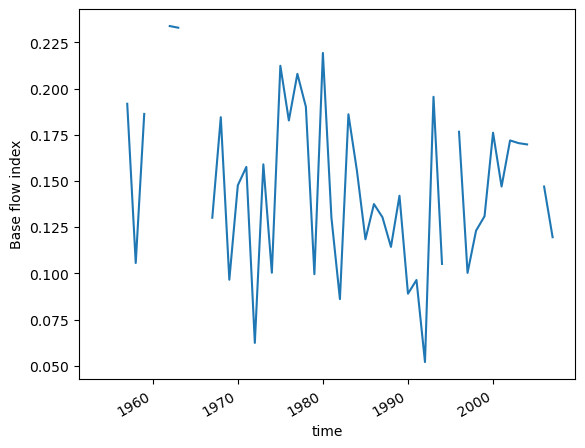

In [2]:
# Mask missing values marked by -1.2345
q = ds.qobs
q = q.where(q != -1.2345)

# Compute base flow index
out = xclim.land.base_flow_index(q)
out.plot()

To compute generic statistics of a time series, use the `stats` indicator.

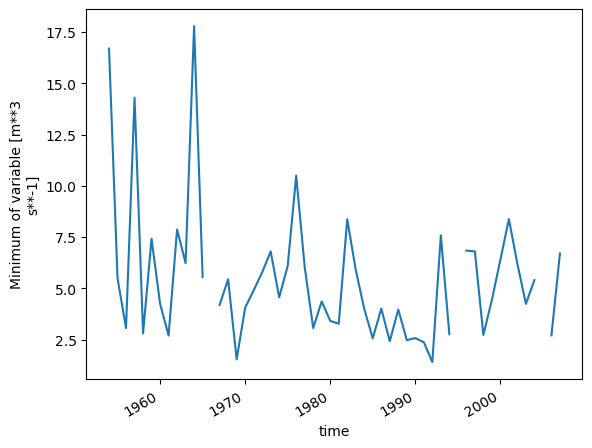

In [3]:
# Here we compute the annual summer (JJA) minimum
out = xclim.generic.stats(q, op="min", season="JJA")
out.plot()

## Frequency analysis

The `freq_analysis` indicator builds on the `stat` indicator, in that it fits a series of annual maxima or minima to a statistical distribution, and returns the values corresponding to different return periods. For example, computing the Q(2,7), the minimum 7-days streamflow with a two-year reoccurrence, can be done using the following.

In [4]:
with xclim.set_options(check_missing="skip"):
    out = xclim.generic.return_level(q, mode="min", t=2, dist="gumbel_r", window=7)
out

<xarray.DataArray 'fa_7minannual' (return_period: 1)>
array([3.93250383])
Coordinates:
  * return_period  (return_period) int64 2
Attributes:
    units:               m**3 s**-1
    original_long_name:  discharge observation
    coordinates:         station_name
    standard_name:       water_volume_transport_in_river_channel
    long_name:           N-year return level
    description:         Frequency analysis for the minimal annual 7-day valu...
    method:              ML
    estimator:           Maximum likelihood
    scipy_dist:          gumbel_r
    history:             [2024-05-30 20:06:19] fa_7minannual: RETURN_LEVEL(da...
    cell_methods:        
    mode:                min

An array of return periods can be passed.

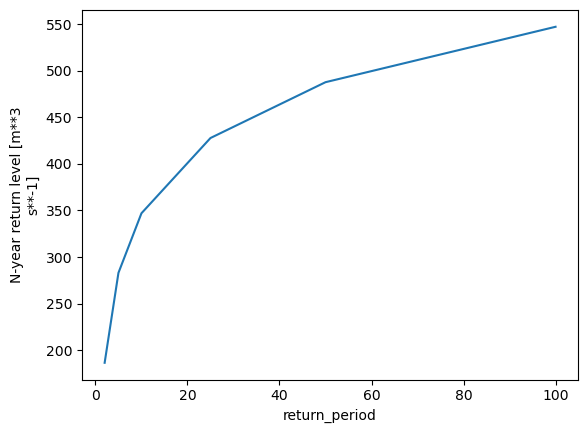

In [5]:
with xclim.set_options(check_missing="skip"):
    out = xclim.generic.return_level(
        q, mode="max", t=(2, 5, 10, 25, 50, 100), dist="gumbel_r"
    )
out.plot()

## Getting the parameters of the distribution and comparing the fit

It's sometimes more useful to store the fitted parameters of the distribution rather than storing only the quantiles. In the example below, we're first computing the annual maxima of the simulated time series, then fitting them to a gumbel distribution using the `fit` process.

In [6]:
import json

with xclim.set_options(
    check_missing="pct", missing_options={"pct": {"tolerance": 0.05}}
):
    ts = xclim.generic.stats(q, op="max")

ts

<xarray.DataArray 'stat_annualmax' (time: 57)>
array([253. ,   nan,   nan, 243. , 231. , 236. ,   nan,   nan, 140. ,
       196. , 264. , 241. ,   nan, 281. , 224. , 129. , 232. , 190. ,
       300. , 240. , 379. , 182. , 328. , 190. , 129. , 285. ,  96.6,
       164. , 325. , 156. , 141. , 137. , 167. , 130. , 211. , 132. ,
       198. , 202. , 153. , 122. , 206. ,   nan, 250. , 358. , 210. ,
       356. , 170. , 170. , 270. , 185. , 144. ,   nan, 138. , 383. ,
         nan,   nan,   nan])
Coordinates:
  * time     (time) datetime64[ns] 1954-01-01 1955-01-01 ... 2010-01-01
Attributes:
    units:          m**3 s**-1
    long_name:      Maximum of variable
    coordinates:    station_name
    standard_name:  water_volume_transport_in_river_channel
    cell_methods:   
    history:        [2024-05-30 20:06:20] stat_annualmax: STATS(da=qobs, op='...
    description:    Annual maximum of variable (annual).

In [7]:
with xclim.set_options(check_missing="skip"):
    pa = xclim.generic.fit(ts, dist="gumbel_r")
pa

<xarray.DataArray 'params' (dparams: 2)>
array([180.41689291,  57.56570171])
Coordinates:
  * dparams  (dparams) <U5 'loc' 'scale'
Attributes: (12/14)
    original_units:          m**3 s**-1
    original_long_name:      Maximum of variable
    coordinates:             station_name
    original_standard_name:  water_volume_transport_in_river_channel
    cell_methods:             time: fit
    history:                 [2024-05-30 20:06:20] stat_annualmax: STATS(da=q...
    ...                      ...
    description:             Parameters of the gumbel_r distribution.
    method:                  ML
    estimator:               Maximum likelihood
    scipy_dist:              gumbel_r
    units:                   
    standard_name:           gumbel_r parameters